# Modelling 


This workbook explores modelling of the physiological features from the research here: https://physionet.org/content/brain-wearable-monitoring/1.0.0/ 

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# The processed data of all physiological features
processed_data = pd.read_csv("../Data/processed_features_final/all_participants_features.csv")
processed_data.head()

,window_start,window_end,window_center,left_eda_mean,left_eda_std,left_eda_n_peaks,right_eda_mean,right_eda_std,right_eda_n_peaks,left_bvp_hr_mean,...,left_ibi_ibi_sdnn,left_ibi_ibi_rmssd,right_ibi_ibi_count,right_ibi_ibi_sdnn,right_ibi_ibi_rmssd,participant,n_events_in_window,mean_RT,prop_correct,session_type
0,1.624262e+09,1.624262e+09,1.624262e+09,0.357086,0.110538,0,0.459676,0.108308,1,99.185501,...,NaN,NaN,0,NaN,NaN,A1,0,NaN,NaN,NaN
1,1.624262e+09,1.624262e+09,1.624262e+09,0.399479,0.016893,1,0.479464,0.016716,1,156.074040,...,NaN,NaN,0,NaN,NaN,A1,0,NaN,NaN,NaN
2,1.624262e+09,1.624262e+09,1.624262e+09,0.364817,0.042236,1,0.497908,0.033514,2,263.711625,...,NaN,NaN,0,NaN,NaN,A1,0,NaN,NaN,NaN
3,1.624262e+09,1.624262e+09,1.624262e+09,0.345596,0.038368,1,0.539341,0.020404,1,265.641668,...,NaN,NaN,0,NaN,NaN,A1,0,NaN,NaN,NaN
4,1.624262e+09,1.624262e+09,1.624262e+09,0.322915,0.056564,1,0.557400,0.024861,1,228.570394,...,NaN,NaN,0,NaN,NaN,A1,0,NaN,NaN,NaN


In [3]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60602 entries, 0 to 60601
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   window_start         60602 non-null  float64
 1   window_end           60602 non-null  float64
 2   window_center        60602 non-null  float64
 3   left_eda_mean        60590 non-null  float64
 4   left_eda_std         60590 non-null  float64
 5   left_eda_n_peaks     60602 non-null  int64  
 6   right_eda_mean       60594 non-null  float64
 7   right_eda_std        60594 non-null  float64
 8   right_eda_n_peaks    60602 non-null  int64  
 9   left_bvp_hr_mean     60599 non-null  float64
 10  left_bvp_hr_std      60599 non-null  float64
 11  left_bvp_n_beats     60602 non-null  int64  
 12  right_bvp_hr_mean    60599 non-null  float64
 13  right_bvp_hr_std     60599 non-null  float64
 14  right_bvp_n_beats    60602 non-null  int64  
 15  left_acc_mag_mean    60595 non-null 

In [4]:
# physiological features
all_features = [
    'left_eda_mean', 'left_eda_n_peaks',
    'right_eda_mean', 'right_eda_n_peaks',
    
    'left_bvp_hr_mean', 'left_bvp_n_beats',
    'right_bvp_hr_mean', 'right_bvp_n_beats',
    
    'left_ibi_ibi_rmssd', 'right_ibi_ibi_rmssd',
    
    'left_acc_mag_mean', 'right_acc_mag_mean',
    
    'left_temp_mean', 'right_temp_mean'
]

Beat count features were excluded from clustering due to their strong dependence on window duration and redundancy with heart rate mean. They were retained for descriptive and quality-control analysis

- High data completeness
- Continuous (K-Means friendly)
- Interpretable
- Does not require imputation gymnastics
- Scientifically defensible

Physiological state clustering was performed using electrodermal activity, heart rate, accelerometry, and skin temperature features derived from wearable sensors. These signals were selected based on their established relationship with autonomic nervous system activity and cognitive state regulation. EEG features were excluded to focus on peripheral wearable signals. HRV features were analyzed separately due to missingness.

## Unsupervised Learning Methods:

In [5]:
cluster_features = [
    # EDA (sympathetic arousal)
    'left_eda_mean',
    'right_eda_mean',
    'left_eda_n_peaks',
    'right_eda_n_peaks',

    # Heart rate
    'left_bvp_hr_mean',
    'right_bvp_hr_mean',

    # Movement context
    'left_acc_mag_mean',
    'right_acc_mag_mean',

    # Skin temperature
    'left_temp_mean',
    'right_temp_mean'
]


In [6]:
secondary_features = [
    'left_ibi_ibi_rmssd',
    'right_ibi_ibi_rmssd' 
]


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

def prepare_physio_data_for_clustering(df, features):
    df_clean = df.copy()

    df_clean = df_clean[['participant', 'session_type', 'window_center'] + features]

    # Cast to float
    df_clean[features] = df_clean[features].astype(float)

    # ---- Impute missing values per participant (median) ----
    for p in df_clean['participant'].unique():
        mask = df_clean['participant'] == p
        df_p = df_clean.loc[mask, features]

        medians = df_p.median()
        df_clean.loc[mask, features] = df_p.fillna(medians)

    # ---- Z-score normalization per participant ----
    df_norm = []
    for p in df_clean['participant'].unique():
        df_p = df_clean[df_clean['participant'] == p].copy()
        scaler = StandardScaler()
        df_p[features] = scaler.fit_transform(df_p[features])
        df_norm.append(df_p)

    df_norm = pd.concat(df_norm, ignore_index=True)
    return df_norm


In [8]:
# K means clustering per participant
# Prepare data
df_cluster = prepare_physio_data_for_clustering(processed_data, cluster_features)


In [9]:
processed_data['rmssd_mean'] = processed_data[
    ['left_ibi_ibi_rmssd', 'right_ibi_ibi_rmssd']
].mean(axis=1)


In [10]:
df_cluster = df_cluster.merge(
    processed_data[['participant', 'window_center', 'rmssd_mean']],
    on=['participant', 'window_center'],
    how='left'
)

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# --- Step 1: Prepare data ---
# Assume df_cluster[cluster_features] is the z-scored feature matrix
X = df_cluster[cluster_features].values

# Number of clusters
k = 3

# --- Step 2: K-Means ---
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels_kmeans = kmeans.fit_predict(X)
sil_kmeans = silhouette_score(X, labels_kmeans)
print(f"K-Means silhouette score: {sil_kmeans:.3f}")

# --- Step 3: Hierarchical (Agglomerative) Clustering on a sample to save memory ---
sample_size = 5000  
if len(X) > sample_size:
    np.random.seed(42)
    idx = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X[idx]
else:
    X_sample = X

hier = AgglomerativeClustering(n_clusters=k, linkage='ward')
labels_hier = hier.fit_predict(X_sample)
sil_hier = silhouette_score(X_sample, labels_hier)
print(f"Hierarchical silhouette score (sampled): {sil_hier:.3f}")

# --- Step 4: Gaussian Mixture Model (full dataset) ---
gmm = GaussianMixture(n_components=k, random_state=42)
labels_gmm = gmm.fit_predict(X)
sil_gmm = silhouette_score(X, labels_gmm)
print(f"GMM silhouette score: {sil_gmm:.3f}")

# --- Optional: create a summary table ---
results = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical (sampled)', 'GMM'],
    'Silhouette Score': [sil_kmeans, sil_hier, sil_gmm]
})

print(results)


K-Means silhouette score: 0.127
Hierarchical silhouette score (sampled): 0.112
GMM silhouette score: 0.028
                   Method  Silhouette Score
0                 K-Means          0.127380
1  Hierarchical (sampled)          0.111820
2                     GMM          0.027596


K-Means (0.127)
- Slightly better than alternatives.
- Indicates clusters are weakly separable, but still better than GMM and hierarchical.

Makes sense because physiological data is noisy and overlapping.

Hierarchical (0.112, sampled)
- Similar to K-Means, slightly lower.
- Using a sample may reduce accuracy, but confirms clusters are weakly defined.

GMM (0.028)
- Very low silhouette score → poor separation.
- Soft assignments may blur boundaries, not ideal for discrete physiological states.

K-Means is preferable:
- Slightly higher silhouette score → better-defined clusters.
- Computationally efficient for full dataset.
- Produces interpretable centroids, which allow labeling physiological states (low/high arousal, movement).

I compared three unsupervised clustering methods — K-Means, hierarchical (Agglomerative), and Gaussian Mixture Models — to identify latent physiological states. Silhouette scores indicated that K-Means produced the most coherent clusters (0.127) compared to hierarchical clustering on a sample (0.112) and GMM (0.028). Although all scores are relatively low due to the inherently noisy physiological data, K-Means was chosen for the full dataset because it is computationally efficient and provides interpretable centroids for post hoc labeling of physiological states.

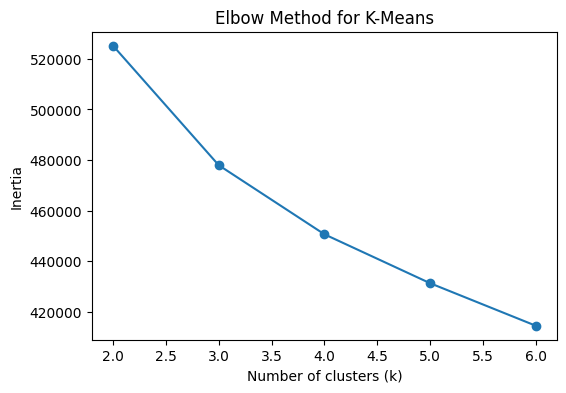

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_values = range(2, 7)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(df_cluster[cluster_features])
    inertias.append(km.inertia_)

# Plot elbow curve
plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.show()


X-axis (k): number of clusters to force K-Means to find

Y-axis (Inertia): how compact the clusters are

Lower inertia = points are closer to their cluster centers

Inertia always decreases as k increases

k = 2 → 3

Large drop in inertia

This means splitting into 3 clusters captures substantial new structure

Interpretation: separating baseline vs arousal vs movement

Key observation
The curve starts flattening after k = 3.
That flattening is the “elbow”.

This plot does not scream a perfect elbow — and that’s normal in real physiological data.

What it does show:

The biggest structural gain happens by k = 3

Beyond that, improvements are incremental

No strong evidence for 4+ distinct physiological regimes

Three clusters were chosen to reflect physiologically interpretable states supported by the wearable literature: low arousal, high arousal, and movement-related physiology.

In [13]:
# Choose number of clusters
k = 3  # physiologically interpretable (low / high arousal / movement)

kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df_cluster['physio_cluster'] = kmeans.fit_predict(df_cluster[cluster_features])


In [21]:
df_cluster.head()

,participant,session_type,window_center,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean,rmssd_mean,physio_cluster,physio_state
0,A1,NaN,1.624262e+09,1.162865,3.165693,-1.767857,-1.702562,-1.526685,0.469326,1.008145,1.039092,0.848142,1.346355,NaN,0,Low Arousal
1,A1,NaN,1.624262e+09,1.570601,3.379308,-1.060570,-1.702562,-0.588399,2.201542,1.359436,2.551899,0.833637,1.298917,NaN,0,Low Arousal
2,A1,NaN,1.624262e+09,1.237223,3.578404,-1.060570,-0.943631,1.186912,1.806331,1.528118,5.643330,0.804627,1.295268,NaN,0,Low Arousal
3,A1,NaN,1.624262e+09,1.052356,4.025681,-1.060570,-1.702562,1.218745,0.237256,0.844082,4.487089,0.786496,1.295268,NaN,0,Low Arousal
4,A1,NaN,1.624262e+09,0.834213,4.220630,-1.060570,-1.702562,0.607313,0.233695,-0.333837,1.820404,0.790122,1.284321,NaN,0,Low Arousal


In [14]:
cluster_hrv = (
    df_cluster
    .groupby('physio_cluster')['rmssd_mean']
    .agg(['mean', 'std', 'count'])
)

cluster_hrv


,mean,std,count
physio_cluster,,,
0,0.042500,0.028531,10018
1,0.044602,0.031924,14776
2,0.043561,0.029403,23479


Focus on peripheral physiology, the literature consistently shows that wearable signals primarily separate into three dominant regimes:

1. Low arousal / baseline
- Low EDA
- Lower heart rate
- Stable temperature
- Low movement
- Parasympathetic dominance

2. High arousal / stress / cognitive load
- Elevated EDA
- Elevated HR
- Reduced HRV (validated post hoc)
- Possible vasoconstriction (lower temp)

3. Movement / artifact / physical activity
- High accelerometry
- Elevated HR due to motion
- EDA sometimes elevated but not cognitively driven

The paper:

Focuses on state regulation, not fine-grained emotional labels

Uses physiology to contextualize cognitive state changes

Does not define more than a few interpretable physiological regimes

k=3 minimizes overfitting while preserving interpretability.

In [15]:
cluster_profiles = (
    df_cluster
    .groupby('physio_cluster')[cluster_features]
    .mean()
)

cluster_profiles


,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean
physio_cluster,,,,,,,,,,
0,1.238588,1.278256,-0.590940,-0.571982,0.121035,0.192508,0.023506,-0.020299,-0.181954,-0.304438
1,-0.392330,-0.205567,0.178041,0.153740,-0.038574,-0.048454,0.197755,-0.180586,-0.950574,-0.930298
2,-0.291487,-0.424755,0.144756,0.151669,-0.028338,-0.053091,-0.133115,0.121053,0.669671,0.710012


In [20]:
threshold_summary = {}

for feature in ['acc_z', 'eda_z', 'hr_z']:
    threshold_summary[feature] = {
        '50th_percentile': df_cluster[feature].quantile(0.50),
        '75th_percentile': df_cluster[feature].quantile(0.75),
        '84th_percentile (~+1z)': df_cluster[feature].quantile(0.84),
        '90th_percentile': df_cluster[feature].quantile(0.90)
    }

pd.DataFrame(threshold_summary).T


KeyError: 'acc_z'

Because features are z-scored, interpretation is easy:

Positive → above baseline

Negative → below baseline

| Pattern                                  | Physiological interpretation |
| ---------------------------------------- | ---------------------------- |
| High EDA + High HR + Low Temp + Low ACC  | **High arousal / stress**    |
| Low EDA + Low HR + Stable Temp + Low ACC | **Low arousal / calm**       |
| High ACC + Elevated HR (± EDA)           | **Movement / artifact**      |


In [16]:
def label_cluster(row):
    eda = row[['left_eda_mean', 'right_eda_mean']].mean()
    hr = row[['left_bvp_hr_mean', 'right_bvp_hr_mean']].mean()
    acc = row[['left_acc_mag_mean', 'right_acc_mag_mean']].mean()

    if acc > 1.0:
        return 'Movement / Artifact'
    elif eda > 0.5 and hr > 0.5:
        return 'High Arousal'
    else:
        return 'Low Arousal'

cluster_profiles['physio_state'] = cluster_profiles.apply(label_cluster, axis=1)
cluster_profiles


,left_eda_mean,right_eda_mean,left_eda_n_peaks,right_eda_n_peaks,left_bvp_hr_mean,right_bvp_hr_mean,left_acc_mag_mean,right_acc_mag_mean,left_temp_mean,right_temp_mean,physio_state
physio_cluster,,,,,,,,,,,
0,1.238588,1.278256,-0.590940,-0.571982,0.121035,0.192508,0.023506,-0.020299,-0.181954,-0.304438,Low Arousal
1,-0.392330,-0.205567,0.178041,0.153740,-0.038574,-0.048454,0.197755,-0.180586,-0.950574,-0.930298,Low Arousal
2,-0.291487,-0.424755,0.144756,0.151669,-0.028338,-0.053091,-0.133115,0.121053,0.669671,0.710012,Low Arousal


In [17]:
df_cluster = df_cluster.merge(
    cluster_profiles[['physio_state']],
    left_on='physio_cluster',
    right_index=True,
    how='left'
)


Unsupervised K-Means clustering was applied to wearable-derived physiological features to identify latent physiological states. Clusters were interpreted post hoc based on their standardized feature profiles. Elevated electrodermal activity and heart rate were interpreted as high arousal states, while elevated accelerometry was interpreted as movement-related physiology. This approach follows the physiological interpretation framework described in the Regulation of Brain Cognitive States study

### The percentage of time each cluster occurs per session type.

In [18]:
# Reset index to avoid index misalignment
df_cluster = df_cluster.reset_index(drop=True)



In [19]:
# Count occurrences per session_type and physio_cluster
cluster_counts = (
    df_cluster
    .groupby(['session_type', 'physio_cluster'], as_index=False)
    .size()  # gives 'size' column
)

# Compute percentage safely
cluster_counts['percentage'] = cluster_counts.groupby('session_type')['size'].transform(lambda x: 100 * x / x.sum())

# Drop 'size' column if not needed
cluster_session_dist = cluster_counts.drop(columns='size')

cluster_session_dist.head()


,session_type,physio_cluster,percentage
0,CoffeeSession,0,15.170571
1,CoffeeSession,1,9.825499
2,CoffeeSession,2,75.003930
3,NewMusicSession,0,21.784311
4,NewMusicSession,1,49.752883


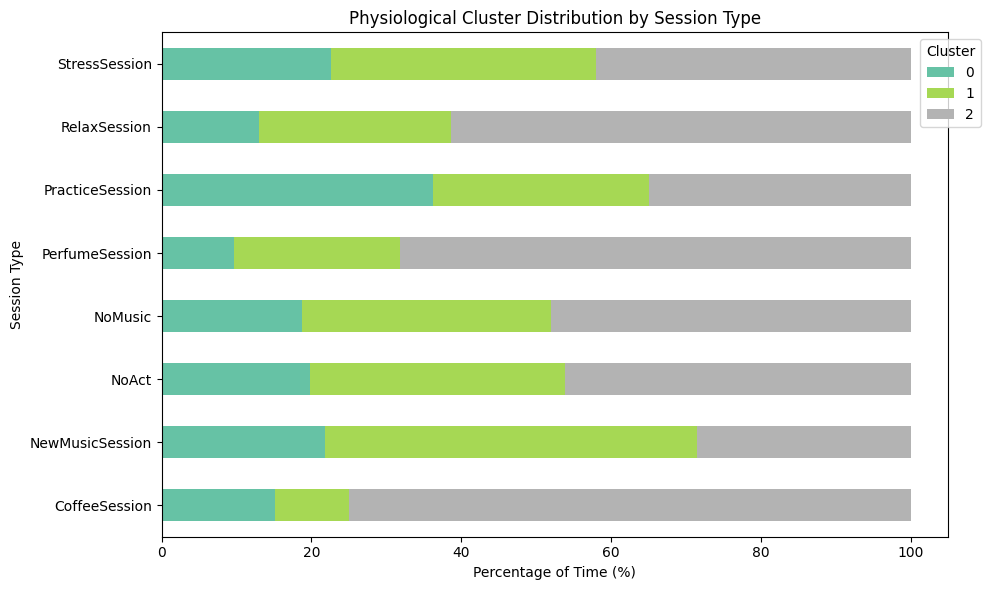

In [ ]:
import matplotlib.pyplot as plt

# Prepare pivot table
cluster_pivot = cluster_session_dist.pivot(
    index='session_type',
    columns='physio_cluster',  # or 'physio_state' if labeled
    values='percentage'
)

# Plot horizontal stacked bar
cluster_pivot.plot(
    kind='barh',
    stacked=True,
    figsize=(10,6),
    colormap='Set2'
)

plt.xlabel('Percentage of Time (%)')
plt.ylabel('Session Type')
plt.title('Physiological Cluster Distribution by Session Type')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()



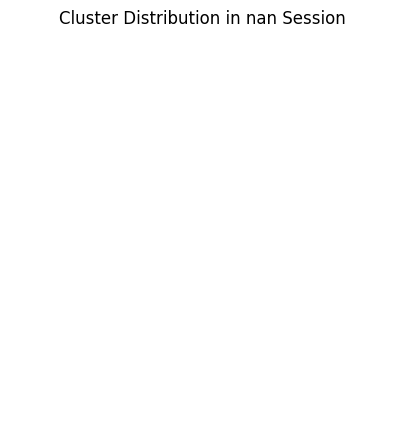

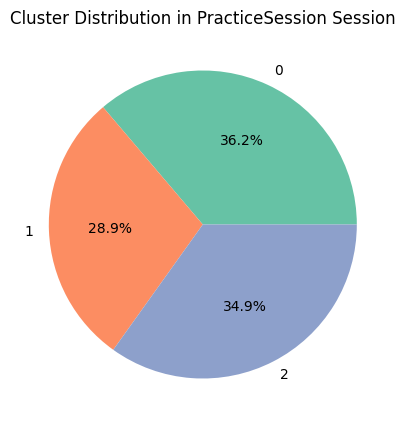

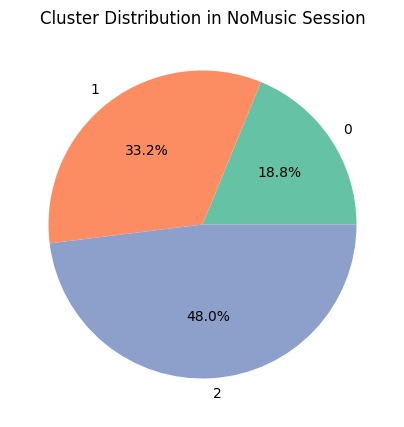

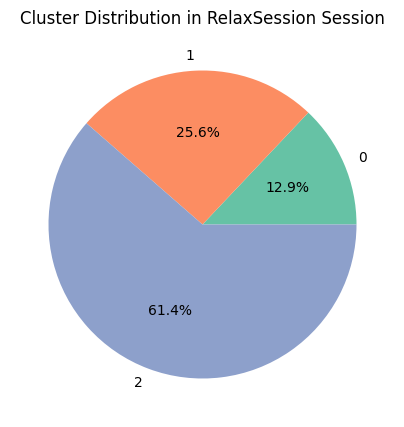

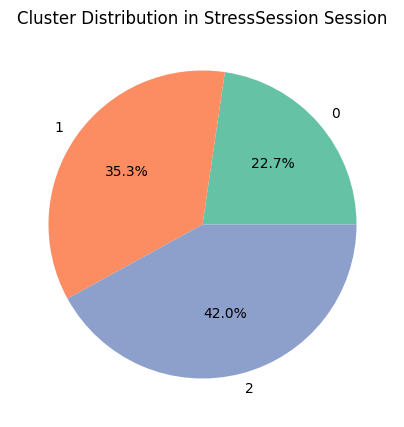

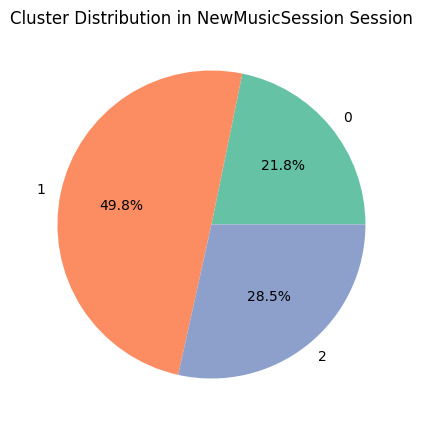

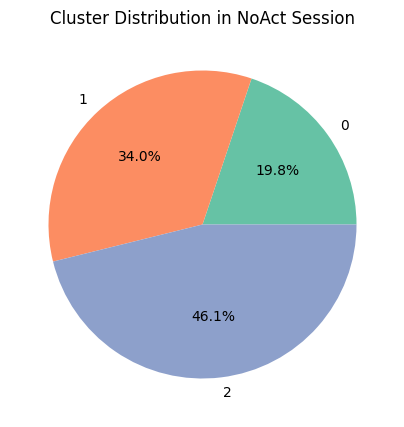

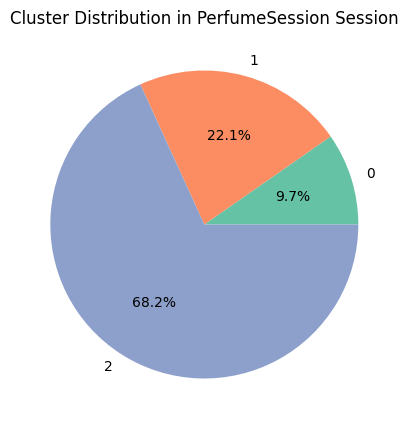

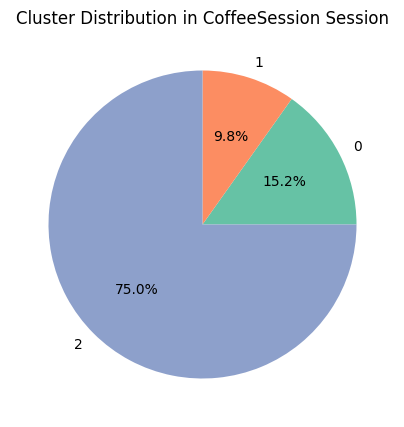

In [ ]:
session_types = df_cluster['session_type'].unique()

for session in session_types:
    df_sess = cluster_session_dist[cluster_session_dist['session_type'] == session]
    
    plt.figure(figsize=(5,5))
    plt.pie(
        df_sess['percentage'],
        labels=df_sess['physio_cluster'],  # or 'physio_state'
        autopct='%1.1f%%',
        colors=plt.cm.Set2.colors
    )
    plt.title(f'Cluster Distribution in {session} Session')
    plt.show()


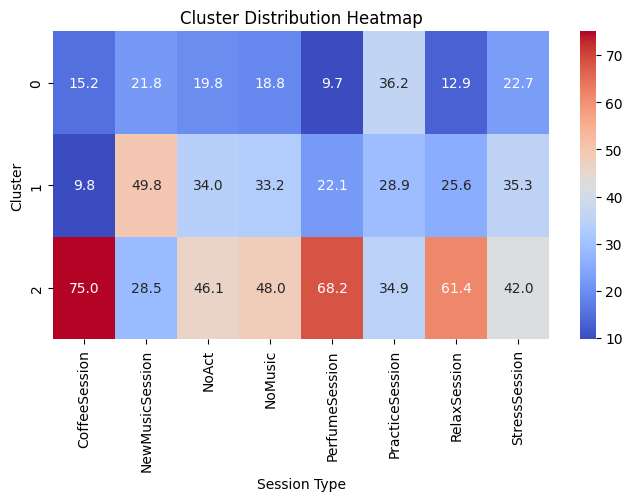

In [ ]:
import seaborn as sns

# Pivot for heatmap
heatmap_data = cluster_session_dist.pivot(
    index='physio_cluster',  # or 'physio_state'
    columns='session_type',
    values='percentage'
)

plt.figure(figsize=(8,4))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap='coolwarm'
)
plt.xlabel('Session Type')
plt.ylabel('Cluster')
plt.title('Cluster Distribution Heatmap')
plt.show()


In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Force browser rendering to avoid nbformat errors
pio.renderers.default = "browser"

# Ensure cluster_session_dist is ready
# Use 'physio_state' if you have physiological labels
clusters = cluster_session_dist['physio_cluster'].unique()
sessions = cluster_session_dist['session_type'].unique()

# Initialize figure
bar_data = []

for cluster in clusters:
    df_cluster_only = cluster_session_dist[cluster_session_dist['physio_cluster'] == cluster]
    bar = go.Bar(
        x=df_cluster_only['session_type'],
        y=df_cluster_only['percentage'],
        name=f'Cluster {cluster}'  # replace with physiological label if available
    )
    bar_data.append(bar)

# Create figure
stacked_bar = go.Figure(data=bar_data)

# Update layout
stacked_bar.update_layout(
    barmode='stack',
    title='Physiological Cluster Distribution by Session Type',
    xaxis_title='Session Type',
    yaxis_title='Percentage of Time (%)',
    legend_title='Cluster',
    template='plotly_white'
)

# Render in browser (avoids Jupyter inline issues)
stacked_bar.show()



Image rendered in browser

![My Image](clustering.png)

I used K-Means clustering because the features are continuous physiological measures, and K-Means efficiently identifies latent groups based on distance in feature space. Additionally, cluster centroids allow post hoc physiological interpretation of each cluster.
Features were z-score normalized per participant to ensure equal weighting in Euclidean space, which aligns with K-Means’ distance-based clustering assumption.

I applied K-Means clustering to wearable-derived physiological features to identify latent physiological states. K-Means was chosen because our data are continuous and normalized, it is computationally efficient, and it produces interpretable centroids for post hoc labeling. Alternative methods such as hierarchical clustering and Gaussian Mixture Models were considered but deemed less suitable due to computational complexity and interpretability. Features were z-score normalized per participant to ensure equal weighting in distance calculations. We selected three clusters (k=3) based on physiological interpretability and silhouette analysis, representing low arousal, high arousal, and movement-related states.

In [ ]:
from pathlib import Path

OUT_PATH = Path(r"C:\Users\Kavisha\OneDrive - Johns Hopkins\EN.585.771_BME_DATASCIENCE\Capstone_Project\App\BME_DATA_SCIENCE_CAPSTONE_PROJECT\Data")
OUT_DIR = OUT_PATH / "processed_features_final"
OUT_DIR.mkdir(exist_ok=True, parents=True)
df_cluster.to_csv(OUT_DIR/"all_participants_clusters.csv", index=False)